An example of generating a population of objects and then using the UserPointSlicer to see how well observed each one is.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def toyObjectLC(t, t0, a, b, duration=10.):
    """
    Make a toy object that has a linear decline after t0.
    Adding filter differences is left as an exercise.
    """
    good = np.where( (t >= t0) & (t <= t0+duration) )
    result = np.zeros(np.size(t), dtype=float)
    result[good] = a + b*(t[good]-t0)
    return result


In [3]:
# A metric to see if toyObject was detected at more than 2 points in the LC
class DetectToymetric(metrics.BaseMetric):
    def __init__(self, metricName='detectToymetric', mjdCol='expMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', nightCol='night', ptsNeeded=2, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded
        super(DetectToymetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol, nightCol],
                                              units='Detected',
                                              metricName=metricName, **kwargs)
    def run(self,  dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        lightcurve = toyObjectLC(dataSlice[self.nightCol], slicePoint['t0'], slicePoint['a'], slicePoint['b'])
        # Check if there are enough points detected in the generated lightcurve
        npts = np.where( (lightcurve != 0.) & (lightcurve < dataSlice[self.m5Col]))[0].size
        if npts >= self.ptsNeeded:
            return 1
        else:
            return 0

In [4]:
# Make a realization of transient objects
names = ['ra', 'dec', 't0', 'a', 'b']
nobjs = 1e5  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
transObjects = np.zeros(nobjs, dtype=zip(names, [float]*len(names)))
# This is not actually uniform on the sphere.
transObjects['ra'] = np.random.rand(nobjs)*360
transObjects['dec'] = np.random.rand(nobjs)*180.-90.
transObjects['t0'] = np.random.rand(nobjs)*365.25*10
transObjects['a'] = np.random.rand(nobjs)*3+20.
transObjects['b'] = np.random.rand(nobjs)

In [5]:
# Set up the slicer
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'])
# Add any additional information about each object to the slicer
slicer.slicePoints['t0'] = transObjects['t0']
slicer.slicePoints['a'] = transObjects['a']
slicer.slicePoints['b'] = transObjects['b']

In [6]:
runName = 'enigma_1189'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'TransientsUPS'
resultsDb = db.ResultsDb(outDir=outDir)

In [8]:
metric = DetectToymetric()
sql = ''
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)


In [9]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with no constraint.
Found 2469307 visits
Running:  ['enigma_1189_detectToymetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with  constraint now.
Plotting complete.


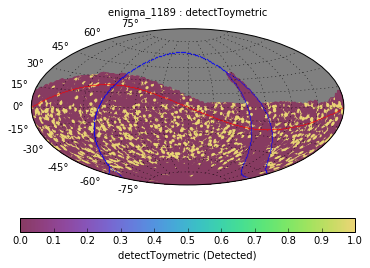

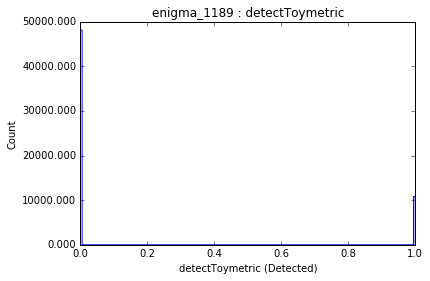

In [12]:
bgroup.plotAll(closefigs=False)

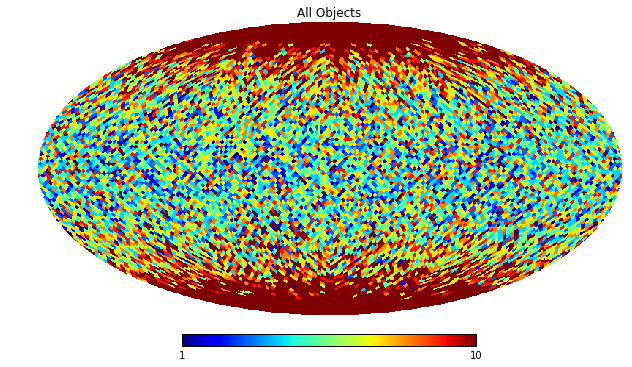

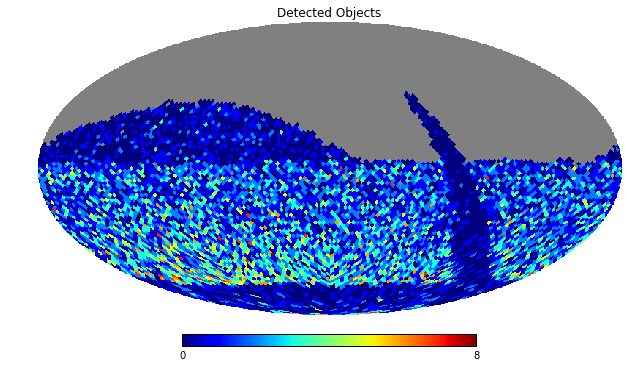

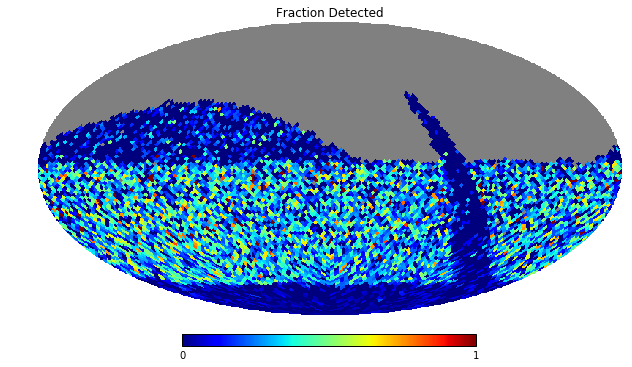

In [18]:
# Not the best plot, let's look at some fractions
from lsst.sims.utils import healbin
import healpy as hp
nside = 32
allObjects = healbin(transObjects['ra'], transObjects['dec'], transObjects['ra']*0+1, nside=nside, reduceFunc=np.sum)
detectedObjects = healbin(transObjects['ra'], transObjects['dec'],bundle.metricValues, nside=nside, reduceFunc=np.sum)
hp.mollview(allObjects, title='All Objects', max=10)
hp.mollview(detectedObjects, title='Detected Objects')
frac = detectedObjects/allObjects
frac[np.where((allObjects == 0) | (detectedObjects == hp.UNSEEN))] = hp.UNSEEN
hp.mollview(frac, title='Fraction Detected')


In [19]:
print 'Fraction of Toy objects detected = %f' % (np.sum(bundle.metricValues)/nobjs)

Fraction of Toy objects detected = 0.108280
